# LIVRABLE 2 

## ÉTAPE 2 : Génération aléatoire des données

In [100]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 500
x_max         = 1000000    # maximum coordinates of a city on the x axis
y_max         = 1000000    # maximum coordinates of a city on the y axis

coords        = np.random.randint([x_max, y_max], size=(number_cities, 2))  # Creation of a random matrix of city coordinates

print(coords)

[[633077 101907]
 [399930 213084]
 [361953 703217]
 [643064 924117]
 [709310  53004]
 [429633 849279]
 [539000   6557]
 [303846 933140]
 [  2058 779235]
 [974713 785580]
 [339267 330769]
 [185829 910482]
 [933401 798031]
 [123136 935378]
 [588656 858918]
 [719712 715271]
 [843575 372294]
 [268325 548351]
 [989820 746037]
 [350244 523837]
 [380822 718045]
 [567963 908758]
 [453281  32650]
 [781641 470371]
 [325966 973028]
 [424520 887610]
 [475178 167114]
 [507884 123956]
 [557360 840653]
 [284085 494607]
 [738699 952230]
 [738653 231984]
 [430026 664278]
 [838651 778817]
 [962297 327385]
 [417662 482910]
 [415614 990118]
 [338995 750769]
 [565546 970528]
 [451817 236799]
 [883653 417131]
 [734121 407361]
 [ 41701 366198]
 [571965 764407]
 [275986 637535]
 [301320 720708]
 [394939 589433]
 [481782 737273]
 [ 63792 527903]
 [357624 849275]
 [978075 986383]
 [783765 273871]
 [375669 549702]
 [806298 278067]
 [268188 349821]
 [166431  71792]
 [578735 666048]
 [496619 651048]
 [428253 86168

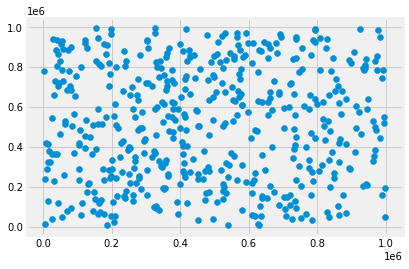

In [101]:
x, y = coords.T    # We define that the first value of coords is X and the second is Y
plt.scatter(x,y)   # Put the x and y axis in pyplot
plt.show()         # Display the coordinates of the cities on an orthonormal coordinate system

In [102]:

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Creation of the matrix of distances between cities
'''
df       = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
distance = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

print(df)
print(distance)

     xcord   ycord
A   633077  101907
B   399930  213084
C   361953  703217
D   643064  924117
E   709310   53004
..     ...     ...
Ȱ   532584  836205
ȱ   833707   47703
Ȳ   131824  212410
ȳ   703820  596699
ȴ   406945  406395

[500 rows x 2 columns]
                A              B              C              D              E  \
A        0.000000  258297.984773  659607.413145  822270.651470   90570.269393   
B   258297.984773       0.000000  491602.085246  751453.304634  348341.198827   
C   659607.413145  491602.085246       0.000000  357519.516000  737179.646232   
D   822270.651470  751453.304634  357519.516000       0.000000  873628.291257   
E    90570.269393  348341.198827  737179.646232  873628.291257       0.000000   
..            ...            ...            ...            ...            ...   
Ȱ   741142.628549  637084.660274  216334.801419  141189.058160  802892.200409   
ȱ   207823.171268  464234.166009  807620.232976  896909.277935  124509.896032   
Ȳ   513288.888461  

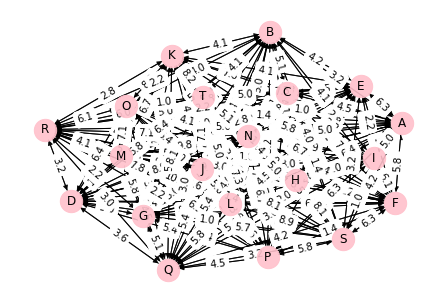

In [38]:
G        = nx.from_numpy_matrix(np.matrix(distance.round(1)), create_using=nx.DiGraph)  # Convert our matrix to a matrix readable by networkx
layout   = nx.spring_layout(G)                                                 # Position the nodes in a plane
labels   = nx.get_edge_attributes(G, "weight")                                 # We recover the weight of the edges

for i in range(number_cities):                                    # Add the name of the cities
    G.add_node(i, desc=cities[i])

node_labels = nx.get_node_attributes(G, 'desc')                   # Get the names of cities
    
nx.draw(G, layout, edge_color='black', width=1, linewidths=1,\
        node_size=500, node_color='pink', alpha=0.9)              # Graph configuration

nx.draw_networkx_labels      (G, pos=layout, labels=node_labels)  # We add the labels of the nodes to the graph
nx.draw_networkx_edge_labels (G, pos=layout, edge_labels=labels)  # We add the labels of the edge to the graph
plt.savefig("Graph.png", format="PNG")                            # We save the graph in a png file
plt.show()                                                        # Display the graph

## ÉTAPE 3 : Modélisation du problème

### - La définition du problème formel

L’ADEME veut trouver de nouvelles solutions permettant de réguler et de réduire l’impact sur l’environnement des livraisons de marchandises.

Pour cela, notre structure CesiCDP doit mettre en place des nouvelles technologies permettant d’optimiser la gestion des ressources et la logistique des trafics routiers.
Nous devons donc gérer une tournée de livraisons grâce aux recherches opérationnelles et au problème du VRP(Vehicle Routing Problem).

Le problème algorithmique consiste donc à calculer sur un réseau routier une tournée permettant de relier entre elles un sous-ensemble de villes, puis de revenir à son point de départ, de manière à minimiser la durée totale de la tournée. Cette optimisation devra tenir compte du trafic prévu sur chaque axe pour les différentes tranches horaires.

### Formulation mathématique:  

La formulation du VRP que nous présentons ici correspond à la formulation mathématique utilisée en programmation linéaire en nombres entiers. Elle traduit la modélisation naturelle du problème par la définition d'une variable binaire **Xijk** égale à 1 si le véhicule **k** parcourt l'arc (Vi, Vj ), noté plus simplement (i, j).

Nous supposons que le graphe G = (V, E) est complet², donc que tous les sommets sont reliés entre eux. Cela signifie qu'une ville peut être visitée à partir de toute autre ville.

Les autres constantes du problème sont les suivantes :
<br>**n** nombre de clients (ou sommets)
<br>**m** nombre de véhicules
<br>**Q** capacité des véhicules
<br>**qi** demande du client i
<br>**Cij** le coût de l'arête entre les sommets i et j (distance ou temps de parcours)

Les variables de décision du problème sont les xijk évoquées plus haut :

Xijk = 1 si(i, j) est parcouru par le vehicule k, ´
<br>Xijk = 0 sinon.

Ainsi, en tant que problème d'optimisation, le VRP s'écrit :
### 1) $\sum \limits _{i=1} ^{n} \sum \limits _{i=1} ^{m} Cij \sum \limits _{i=1} ^{m} Xijk$

<br>

Un graphe complet à n sommets possède n(n−1) 2 arêtes :
### 2)  $\sum \limits _{i=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ j ≤ n$

### 3)  $\sum \limits _{j=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ i ≤ n$

### 4)  $\sum \limits _{i=1} ^{n} \sum \limits _{l=1} ^{n} Xijk = \sum \limits _{l=1} ^{n}\sum \limits _{j=1} ^{n} Xijk$

### 5)  $\sum \limits _{j=1} ^{n} X0jk = 1 ∀ 1 ≤ k ≤ m$

### 6)  $\sum \limits _{i=1} ^{n} Xi0k = 1 ∀ 1 ≤ k ≤ m$

### 7)  $\sum \limits _{i=1} ^{n} \sum \limits _{j=1} ^{n} Xijk ≤ Q ∀ 1 ≤ k ≤ m$


#### Xijk ∈ 0, 1 ∀ 0 ≤ i, j ≤ n; 1 ≤ k ≤ m

Sous cette formulation, (1) signifie que l'objectif du problème d'optimisation est de minimiser la somme des coûts de toutes les tournées.
Les contraintes (2) et (3) imposent que chaque client soit desservi une et une seule fois et les contraintes (4) assurent la conservation de flot. Les contraintes (5) assurent que chaque tournée commence et se termine au dépôt. 
Finalement, les contraintes (6) sont les contraintes de capacité et les contraintes (7) sont des contraintes de binarité sur les variables de décision Xijk.



### - L'étude de complexité de ce problème

### Preuve que VRP à "au moins" la compléxité de TSP

Le problème de tournées de véhicules est NP difficile.

Comme ce n'est pas un problème de décision (son type de retour n'est pas bool), il ne peut pas être dans NP, bien qu'il ait des versions de décision qui le sont.

Ce problème est une généralisation naturelle d'un problème (VDC) qui est déjà NP difficile, en particulier le problème du voyageur de commerce.
Pour prouver qu'un problème est NP difficile, il suffit d'y réduire un autre problème NP difficile. Le VDC est trivialement réduit à une instance VRP avec un véhicule disponible.


### Preuve que TSP est np-complet
Il faut montrer deux choses, à savoir que Travelling Salesman (TSP) est en NP et que TSP est NP-Hard. Ces exigences découlent de la définition de NP-Complétude.


**Partie 1 : TSP est dans NP**

Preuve : Soit un indice S qui est une suite de sommets V = v1,...,vn.
Nous vérifions ensuite deux choses, à savoir que chaque arête traversée par des sommets adjacents est une arête dans G (généralement pas nécessaire, puisque G est traditionnellement un graphe complet), tel que la somme de ces poids d'arête est inférieure ou égale à k.
Deuxièmement, nous vérifions que chaque sommet de G est dans V, ce qui garantit que chaque nœud a été traversé.
On accepte S si et seulement si S satisfait à ces deux questions, sinon on rejette. Ces deux vérifications sont clairement polynomiales, ainsi notre algorithme forme un vérificateur avec l'indice S, et TSP est par conséquent dans NP.

**Partie 2 : TSP est NP-Hard**


Preuve : Pour montrer que TSP est NP-Hard, nous devons montrer que tout problème y dans NP se réduit à TSP en temps polynomial. 

Pour ce faire, considérons la version décisionnelle du cycle hamiltonien (HC).
Il est bien connu que HC est NP-Complet, donc HC est NP-Hard et chaque problème "Y" dans NP se réduit à HC en temps polynomial.
Si nous réduisons HC à TSP en temps polynomial, alors nous aurons montré que tout "Y" dans NP réduit à TSP est un temps polynomial, puisque la somme de deux polynômes est aussi un polynôme.

**Rappelons que la version de décision de HC est :**  
Étant donné un graphe G=(V,E), existe-t-il un cycle simple dans G qui parcourt chaque sommet exactement une fois ?  
Observez maintenant qu'un cycle simple sur n sommets a n arêtes.  


**Maintenant, pour réduire HC en TSP, utilisez l'algorithme suivant:**  

Prenez G=(V,E), définissez tous les poids d'arête égaux à 1, et laissez k = |V|=n, c'est-à-dire que k est égal au nombre de nœuds dans G.  
Toute arête qui n'est pas à l'origine dans G reçoit alors un poids de 2 (traditionnellement, TSP est sur un graphe complet, nous devons donc ajouter ces arêtes supplémentaires). Passez ensuite ce graphe modifié dans TSP, en demandant s'il existe un Tour sur G avec un coût d'au plus k.  
Si la réponse à TSP est OUI, alors HC est OUI. De même, si TSP est NON, alors HC est NON.

Preuve : Nous devons montrer que la réduction prend un temps polynomial et que les solutions de HC sont en correspondance 1-1 avec les solutions de TSP utilisant la réduction. De toute évidence, la réduction prend un temps polynomial, nous nous retrouvons donc avec ce dernier.

Première direction : HC a une réponse OUI => TSP a une réponse OUI.
Preuve : Si HC a une réponse OUI, alors il existe un cycle simple C qui visite chaque nœud exactement une fois, donc C a n arêtes. Étant donné que chaque arête a un poids 1 dans l'instance TSP correspondante pour les arêtes qui sont dans le graphique HC, il existe un Tour de poids n. Puisque k=n, et étant donné qu'il y a un Tour de poids n, il s'ensuit que TSP a une réponse OUI.

Deuxième direction : HC a une réponse NON => TSP a une réponse NON.
Preuve : Si HC a une réponse NON, alors il n'existe pas de cycle simple C dans G qui visite chaque sommet exactement une fois.  
Supposons maintenant que TSP a une réponse OUI. Ensuite, il y a un tour qui visite chaque sommet une fois avec un poids d'au plus k. Puisque le Tour nécessite que chaque nœud soit traversé, il y a n arêtes, et puisque k=n, chaque arête traversée doit avoir un poids 1, ce qui implique que ces arêtes sont dans le graphe HC. Ensuite, faites ce tour et traversez les mêmes arêtes dans l'instance HC. Cela forme un cycle hamiltonien, une contradiction.

Ceci conclut la partie 2. Puisque nous avons montré que TSP est à la fois dans NP et NP-Hard, nous avons que TSP est NP-Complet, comme requis.

### Conculision

Etant donnée que VRP est "au moins" de la meme compléxité que TSP et que VRP n'est pas NP. Cela veut dire que VRP est forcément NP-difficile.

# Étape 4: Modélisation Algorithmique

## 1 - Description de l'algorithme utilisé pour résoudre VRP

### Pourquoi utilisé l'algorithme de colonies de fourmis

D'après des études effectué pour connaitre le meilleur algorithme.  

Pour un peu nombre de noeud:

La recherche tabou et le recuit simulé ont des meilleurs performance que les autres algorithme. Que ce soit sur la qualité de solution, la vitesse d'algorithme mais aussi sur la stabilité des resultats, la recherche tabou et le recuit simulé ont les meilleurs performances.
On peu noté que la différence de qualité de la solution est particulièrement visible pour les cas de test plus importants.

Pour un cas d'un grand nombre de noeud:
Les méthodes de recherche taboue et de recuit simulé donnent solution avec des différences très similaires et performantes. 
Mais un meilleur résultat dans presque tous les cas donne l'algorithme d'optimisation des colonies de fourmis. 

Conclusion:  
L'algorithme le plus adapté est donc l'algorithme de fourmis, car on possède un grand nombre de noeud.

### Explication de l'algorithme de colonies de fourmis

L’idée originale provient de l’observation de l’exploitation des ressources alimentaires chez les fourmis. En effet, celles-ci, bien qu’ayant individuellement des capacités cognitives limitées, sont capables collectivement de trouver le chemin le plus court entre une source de nourriture et leur nid.  

Des biologistes ont ainsi observé, dans une série d’expériences menées à partir de 1989, qu’une colonie de fourmis ayant le choix entre deux chemins d’inégale longueur menant à une source de nourriture avait tendance à utiliser le chemin le plus court.  
Un modèle expliquant ce comportement est le suivant :  
1.	une fourmi (appelée « éclaireuse ») parcourt plus ou moins au hasard l’environnement autour de la colonie ;  
2.	si celle-ci découvre une source de nourriture, elle rentre plus ou moins directement au nid, en laissant sur son chemin une piste de phéromones ;  
3.	ces phéromones étant attractives, les fourmis passant à proximité vont avoir tendance à suivre, de façon plus ou moins directe, cette piste ;  
4.	en revenant au nid, ces mêmes fourmis vont renforcer la piste ;  
5.	si deux pistes sont possibles pour atteindre la même source de nourriture, celle étant la plus courte sera, dans le même temps, parcourue par plus de fourmis que la longue piste;  
6.	la piste courte sera donc de plus en plus renforcée, et donc de plus en plus attractive ;  
7.	la longue piste, elle, finira par disparaître, les phéromones étant volatiles ;  
8.	à terme, l’ensemble des fourmis a donc déterminé et « choisi » la piste la plus courte.  
<br><br><br>

L'algorithme de colonies de fourmis vise à résoudre le problème du voyageur de commerce, où le but est de trouver le plus court chemin permettant de relier un ensemble de villes.  
L’algorithme général est relativement simple, et repose sur un ensemble de fourmis, chacune parcourant un trajet parmi ceux possibles.  
À chaque étape, la fourmi choisit de passer d’une ville à une autre en fonction de quelques règles :  
1.	elle ne peut visiter qu’une fois chaque ville ;  
2.	plus une ville est loin, moins elle a de chance d’être choisie (c’est la « visibilité ») ;  
3.	plus l'intensité de la piste de phéromone disposée sur l’arête entre deux villes est grande, plus le trajet aura de chance d’être choisi ;  
4.	une fois son trajet terminé, la fourmi dépose, sur l’ensemble des arêtes parcourues, plus de phéromones si le trajet est court ;  
5.	les pistes de phéromones s’évaporent à chaque itération.  








## 2 - code Python implémentant le modèle

In [7]:

'''
Matrice des distance
'''
print(distance)

'''
Recuperer les 
'''




          A          B          C         D         E
A  0.000000   6.000000   8.062258  3.162278  6.708204
B  6.000000   0.000000  10.630146  3.162278  6.708204
C  8.062258  10.630146   0.000000  9.848858  4.472136
D  3.162278   3.162278   9.848858  0.000000  7.000000
E  6.708204   6.708204   4.472136  7.000000  0.000000


'\nRecuperer les \n'

## 3 - Modèle linéaire

FAIRE X = Combinaison du chemin
ET Y le poids total
(Je pense (peut etre))

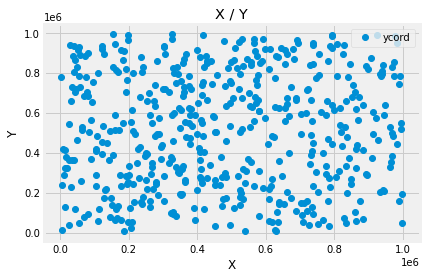

In [103]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

df.plot(x='xcord', y='ycord', style='o')  
plt.title('X / Y')  
plt.xlabel('X')  
plt.ylabel('Y')  
plt.show()

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='xcord', ylabel='Density'>

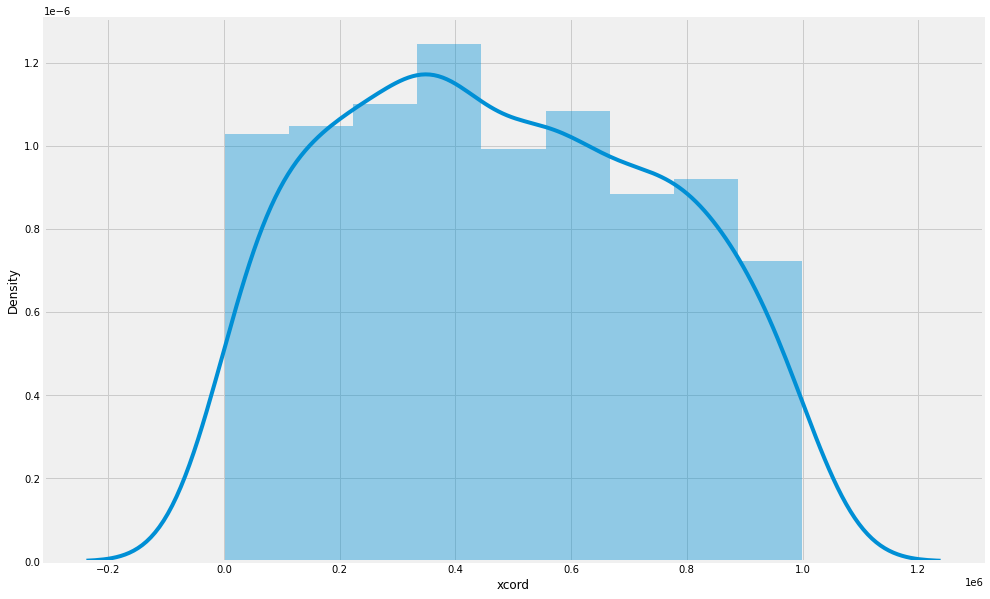

In [104]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df['xcord'])

In [105]:
X = df['xcord'].values.reshape(-1,1)
Y = df['ycord'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

Y_pred = regressor.predict(X_test)

df1 = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})
df1


[495941.12253461]
[[0.03197873]]


,Actual,Predicted
0,121512,508462.872557
1,591619,504374.168529
2,859620,504954.646372
3,843024,526029.842294
4,821271,515433.627327
...,...,...
95,602244,506569.540079
96,666048,514448.330787
97,174885,500045.016457
98,134052,501356.751838


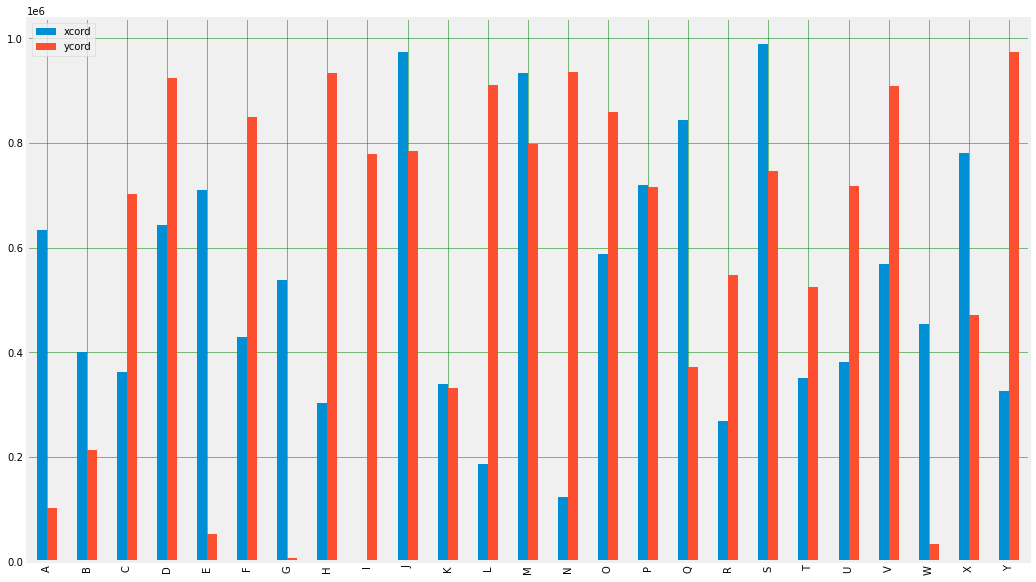

In [106]:
df2 = df.head(25)
df2.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

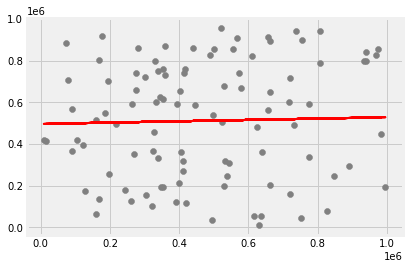

In [107]:
plt.scatter(X_test, Y_test,  color='gray')
plt.plot(X_test, Y_pred, color='red', linewidth=2)
plt.show()

Regression Coefficients: [[-0.02701411]]
-------------------------

coefficient of determination: -0.0032967439478772675
-------------------------

Variance score: -0.01649141857363179
-------------------------




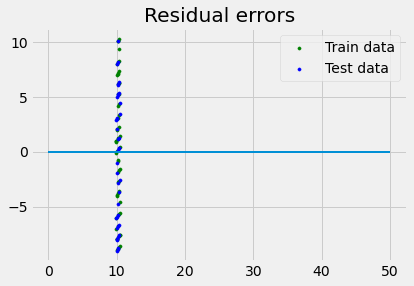

In [59]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

splited_coords = np.hsplit(coords,2)
X = splited_coords[0]
Y = splited_coords[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)

# Create linear regression object AND Train the model using the training sets
model = LinearRegression().fit(X_train, Y_train)

# The regression coefficients
print('Regression Coefficients:', model.coef_)
print("-------------------------\n")

# coefficient of determination
r_sq = model.score(X, Y)
print('coefficient of determination:', r_sq)
print("-------------------------\n")

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model.score(X_test, Y_test)))
print("-------------------------\n\n")

## setting plot style
plt.style.use('fivethirtyeight')
 
## plotting residual errors in training data
plt.scatter(model.predict(X_train), model.predict(X_train) - Y_train,
            color = "green", s = 10, label = 'Train data')
 
## plotting residual errors in test data
plt.scatter(model.predict(X_test), model.predict(X_test) - Y_test,
            color = "blue", s = 10, label = 'Test data')
 
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## method call for showing the plot
plt.show()

## CODE Python ALGORITHME DE FOURMI (CA MARCHE MAIS J AI PAS TOUT COMPRIS ENCORE ET J ARRIVE PAS A METTRE LES VRAI NOM DE VILLE)

In [101]:
import  random                     as rn
from    numpy.random import choice as np_choice

def AntColony(distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
    """
    Args:
        distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
        n_ants (int): Number of ants running per iteration
        n_best (int): Number of best ants who deposit pheromone
        n_iteration (int): Number of iterations
        decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
        alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
        beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
    Example:
        ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
    """
    
    pheromone              = np.ones(distances.shape) / len(distances)
    all_inds               = range(len(distances))
    shortest_path          = None
    all_time_shortest_path = ("placeholder", np.inf)
    
    
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, alpha, beta, all_inds)
        spread_pheronome(all_paths, n_best, pheromone, shortest_path=shortest_path)
        shortest_path = min(all_paths, key=lambda x: x[1])
        #print (shortest_path)
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path            
        pheromone = pheromone * decay            
    return all_time_shortest_path
    
def spread_pheronome(all_paths, n_best, pheromone, shortest_path):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / distances[move]

def gen_path_dist(path):
    total_dist = 0
    for ele in path:
        total_dist += distances[ele]
    return total_dist

def gen_all_paths(n_ants, pheromone, alpha, beta, all_inds):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, alpha, beta, all_inds)
        all_paths.append((path, gen_path_dist(path)))
    return all_paths

def gen_path(start, pheromone, alpha, beta, all_inds):
    path    = []
    visited = set()
    visited.add(start)
    prev    = start
    
    for i in range(len(distances) - 1):
        move = pick_move(pheromone[prev], distances[prev], visited, alpha, beta, all_inds)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start)) # going back to where we started    
    return path

def pick_move(pheromone, dist, visited, alpha, beta, all_inds):
    pheromone = np.copy(pheromone)
    pheromone[list(visited)] = 0

    row      = pheromone ** alpha * (( 1.0 / dist) ** beta)

    norm_row = row / row.sum()
    move     = np_choice(all_inds, 1, p=norm_row)[0]
    return move


number_of_ants                  = 2
distance_ant                    = distance_matrix(df.values, df.values)
distance_ant[distance_ant == 0] = np.inf

print(distance_ant)

shortest_path               =  AntColony(distance_ant, number_of_ants, 20, 100, 0.95, alpha=1, beta=1)

print ("shorted_path: {}".format(shortest_path))

[[       inf 3.         3.16227766 1.41421356 6.40312424]
 [3.                inf 5.         2.23606798 4.47213595]
 [3.16227766 5.                inf 4.47213595 6.08276253]
 [1.41421356 2.23606798 4.47213595        inf 6.40312424]
 [6.40312424 4.47213595 6.08276253 6.40312424        inf]]
shorted_path: ([(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)], 9.0)
